# Task 4: Bucket FICO scores
Now that you are familiar with the portfolio and personal loans and risk are using your model as a guide to loss provisions for the upcoming year, the team now asks you to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. Charlie wants to build a machine learning model that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. She asks if you can find the best way of doing this to allow her to analyze the data.

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors. FICO scores are used in 90% of mortgage application decisions in the United States. The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to construct a technique for predicting the PD (probability of default) for the borrowers using these scores. 

Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data. You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Read Data

In [5]:
df = pd.read_csv("./Loan_Data.csv")

In [6]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


# Data Summary and Description

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [9]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


# Data Preprocessing

In [11]:
# Checking for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


# Analyze FICO score distribution

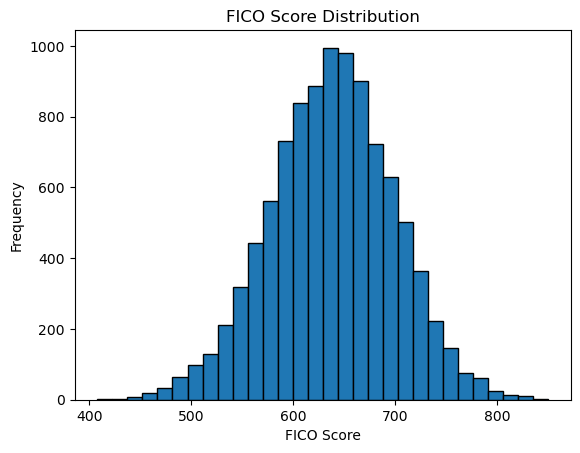

In [13]:
fico_scores = df['fico_score']
plt.hist(fico_scores, bins=30, edgecolor='black')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('FICO Score Distribution')
plt.show()

# Define quantization function to optimize boundaries

In [15]:
def mse_bucket_loss(boundaries, scores):
    boundaries = np.sort(boundaries)
    bucketed_scores = np.digitize(scores, boundaries)
    mean_per_bucket = [scores[bucketed_scores == i].mean() for i in range(len(boundaries) + 1)]
    mse = np.mean([(scores[i] - mean_per_bucket[bucketed_scores[i]])**2 for i in range(len(scores))])
    return mse

In [16]:
# Initial boundaries guess (evenly spaced)
initial_boundaries = np.linspace(fico_scores.min(), fico_scores.max(), num=5)[1:-1]

# Optimize boundaries

In [18]:
result = minimize(mse_bucket_loss, initial_boundaries, args=(fico_scores,), method='Powell')
optimal_boundaries = np.sort(result.x)

# Assign buckets based on optimized boundaries

In [20]:
df['fico_bucket'] = np.digitize(df['fico_score'], optimal_boundaries)
df['fico_rating'] = df['fico_bucket'].max() - df['fico_bucket']  # Lower rating = better score

In [21]:
# Display optimized boundaries and data preview
print("Optimized FICO Buckets:", optimal_boundaries)
print(df[['fico_score', 'fico_bucket', 'fico_rating']].head(10))

Optimized FICO Buckets: [574.24010888 635.57416804 694.20748725]
   fico_score  fico_bucket  fico_rating
0         605            1            2
1         572            0            3
2         602            1            2
3         612            1            2
4         631            1            2
5         697            3            0
6         722            3            0
7         545            0            3
8         676            2            1
9         447            0            3


FICO scores into four buckets:

- Bucket 0: FICO scores ≤ 574
- Bucket 1: 574 < FICO scores ≤ 635
- Bucket 2: 635 < FICO scores ≤ 694
- Bucket 3: FICO scores > 694

In [23]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,fico_bucket,fico_rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1,2
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0,3
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1,2
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1,2
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,1,2


# Visualizations

In [25]:
fico_scores = df['fico_score']
fico_buckets = df['fico_bucket']
bucket_boundaries = [574.24, 635.57, 694.21] 

C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


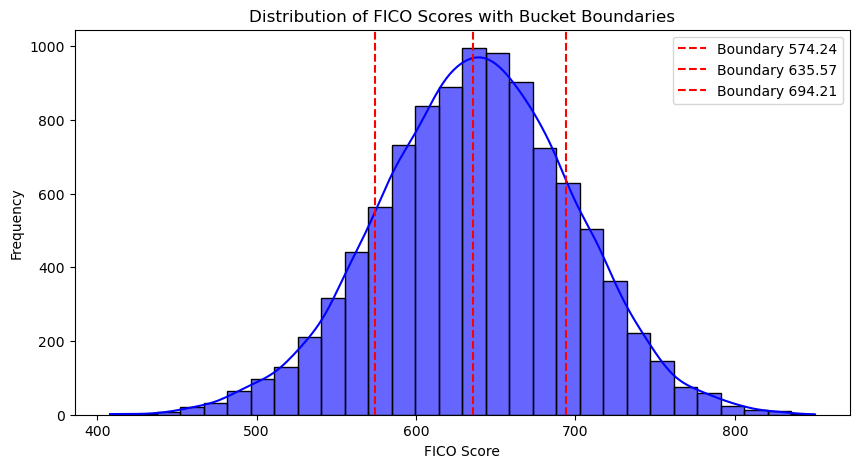

In [26]:
# Histogram of FICO Scores with Bucket Boundaries
plt.figure(figsize=(10, 5))
sns.histplot(fico_scores, bins=30, kde=True, color='blue', alpha=0.6)
for boundary in bucket_boundaries:
    plt.axvline(boundary, color='red', linestyle='dashed', label=f'Boundary {boundary:.2f}')
plt.xlabel("FICO Score")
plt.ylabel("Frequency")
plt.title("Distribution of FICO Scores with Bucket Boundaries")
plt.legend()
plt.show()

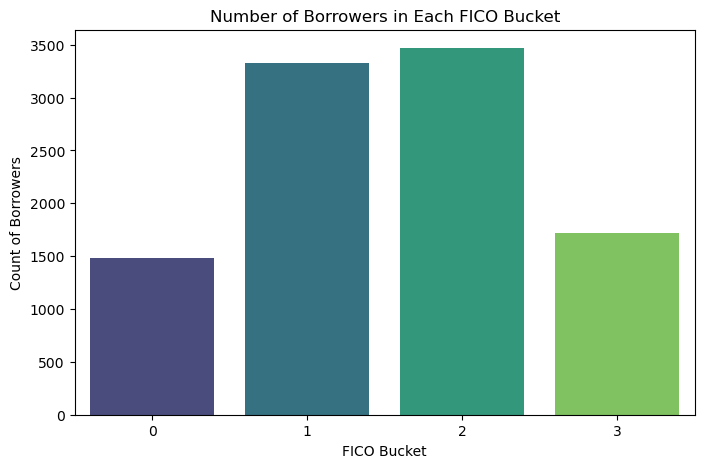

In [27]:
# Countplot of FICO Buckets
plt.figure(figsize=(8, 5))
sns.countplot(x=fico_buckets, palette="viridis")
plt.xlabel("FICO Bucket")
plt.ylabel("Count of Borrowers")
plt.title("Number of Borrowers in Each FICO Bucket")
plt.show()

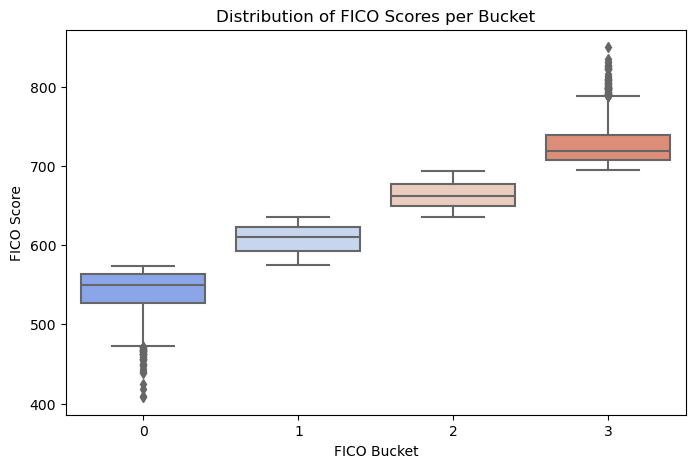

In [28]:
# Boxplot of FICO Scores per Bucket
plt.figure(figsize=(8, 5))
sns.boxplot(x=fico_buckets, y=fico_scores, palette="coolwarm")
plt.xlabel("FICO Bucket")
plt.ylabel("FICO Score")
plt.title("Distribution of FICO Scores per Bucket")
plt.show()